# Debugging FBP code

_Srayan Gangopadhyay_  
_Thu 9 Mar 2023_

The key question: why does ASTRA give a dark reconstruction from brightfield images?

The strategy: compare outputs from skimage and ASTRA with sample phantoms.

### Sources
- https://scikit-image.org/docs/stable/auto_examples/transform/plot_radon_transform.html
- https://github.com/astra-toolbox/astra-toolbox/blob/master/samples/python/s014_FBP.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, iradon
import astra
import scipy.io

In [2]:
phantom = scipy.io.loadmat(r'D:\MSci_Project\1_Data\phantom.mat')['phantom256']

In [3]:
def compare_recons(phantom):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    mpbl = axs[0].imshow(phantom, cmap='gray')
    plt.colorbar(mpbl)
    axs[0].set_title('Image')

    # generate sinogram with ASTRA
    vol_geom = astra.create_vol_geom(256, 256)
    proj_geom = astra.create_proj_geom('parallel', 1.0, 256, np.linspace(0,np.pi,180,False))
    proj_id = astra.create_projector('cuda', proj_geom, vol_geom)
    sinogram_id, sinogram_astra = astra.create_sino(phantom, proj_id)

    mpbl = axs[1].imshow(sinogram_astra.T, cmap='gray')
    plt.colorbar(mpbl)
    axs[1].set_title('ASTRA sinogram')

    # generate sinogram with skimage
    theta = np.linspace(0., 180., max(phantom.shape), endpoint=False)
    sinogram_skimage = radon(phantom, theta=theta)
    dx, dy = 0.5 * 180.0 / max(phantom.shape), 0.5 / sinogram_skimage.shape[0]

    mpbl = axs[2].imshow(sinogram_skimage, cmap='gray',
               extent=(-dx, 180.0 + dx, -dy, sinogram_skimage.shape[0] + dy),
               aspect='auto')
    plt.colorbar(mpbl)
    axs[2].set_title('skimage sinogram')

    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    rec_id = astra.data2d.create('-vol', vol_geom)
    cfg = astra.astra_dict('FBP_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['option'] = { 'FilterType': 'Ram-Lak' }
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)
    recon_astra = astra.data2d.get(rec_id)

    mpbl = axs[0].imshow(recon_astra, cmap='gray')
    plt.colorbar(mpbl)
    axs[0].set_title('ASTRA recon')

    recon_skimage = iradon(sinogram_skimage, theta=theta, filter_name='ramp')

    mpbl = axs[1].imshow(recon_skimage, cmap='gray')
    plt.colorbar(mpbl)
    axs[1].set_title('skimage recon')

    plt.show()

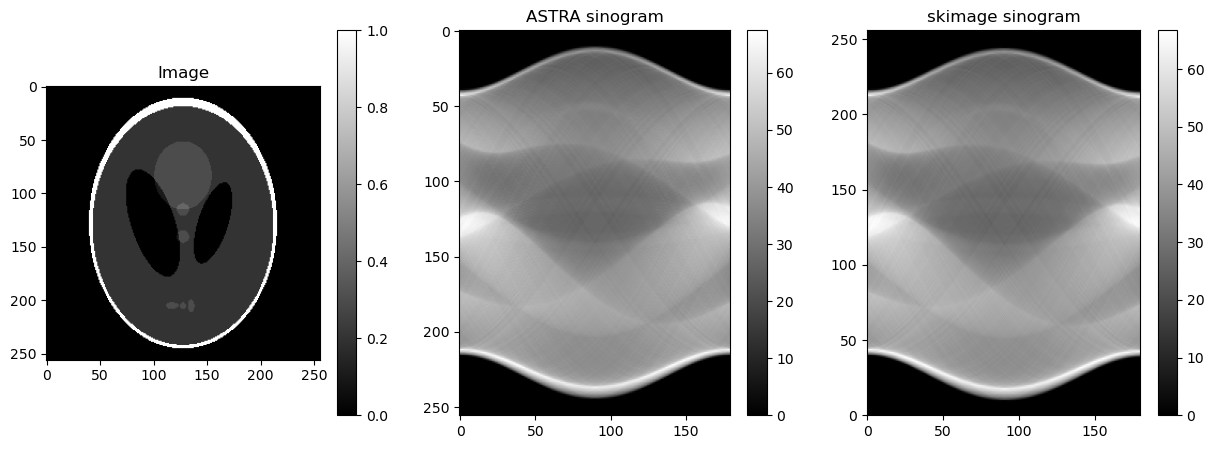

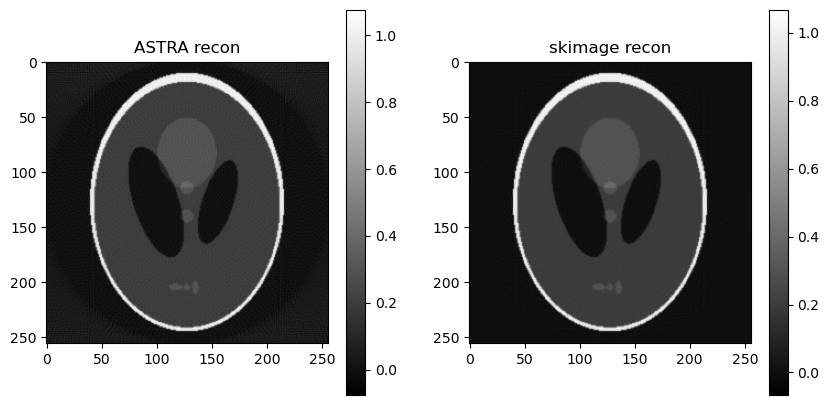

In [4]:
compare_recons(phantom)

In [29]:
bright_phantom = scipy.io.loadmat(r'D:\MSci_Project\1_Data\phantom.mat')['phantom256']

bright_phantom[:, 0:35] = 0.9
bright_phantom[:, 256-35:] = 0.9
bright_phantom[0:10, :] = 0.9
bright_phantom[256-10:, :] = 0.9

D:\anaconda3\envs\opt\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


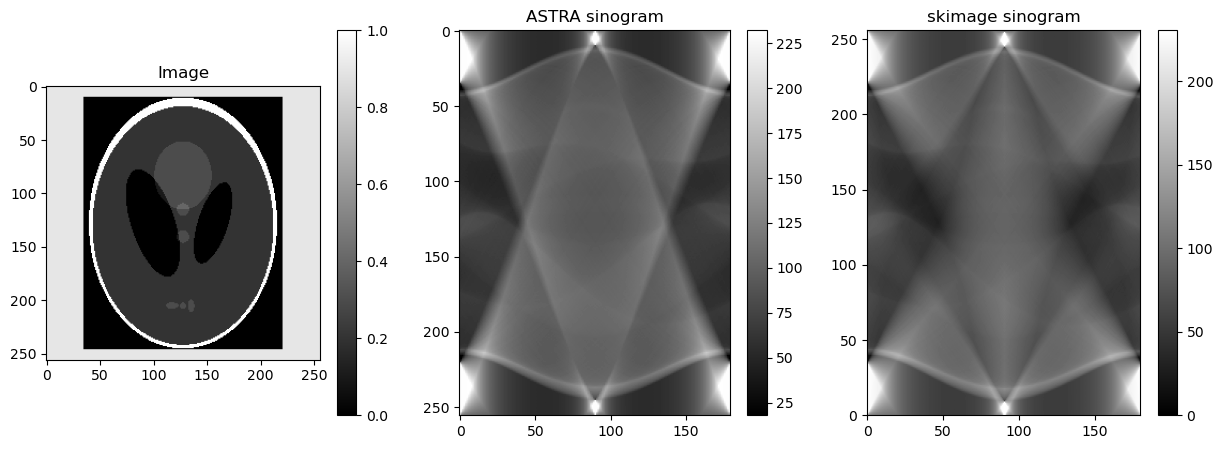

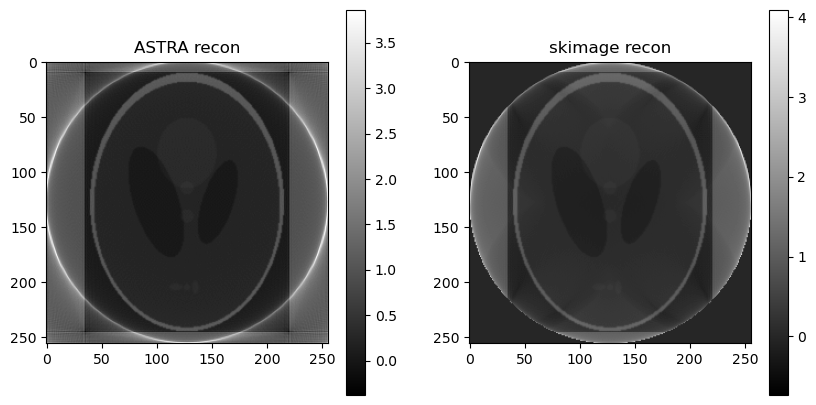

In [30]:
compare_recons(phantom)